In [5]:
#%% imports
import json
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import rasterio

root_directory = Path().resolve().parents[1]
# add path to Norway shapes in data to path
path_to_shape = root_directory / 'data'/'raw'/'maps'/'Norway_boundaries'/'NOR_adm0.shp'
# any shape file of Norway that doesn't include svalbard should be fine, I took mine from
# https://earthworks.stanford.edu/catalog/stanford-jm135gj5367


# load the metadata
metadata_file = 'metadata_all_projects_20240523000926.json'
path_to_data = root_directory / 'data' / 'raw' / 'orthophoto'

with open(path_to_data / metadata_file, 'r') as f:
    metadata_all_projects = json.load(f)

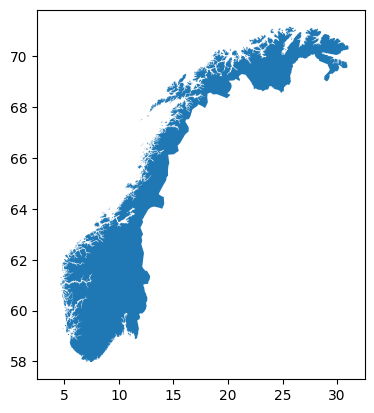

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import shape
# Load the shapefile
Norway = gpd.read_file(path_to_shape)
Norway.plot()
plt.show()

EPSG:4326
None


<Axes: >

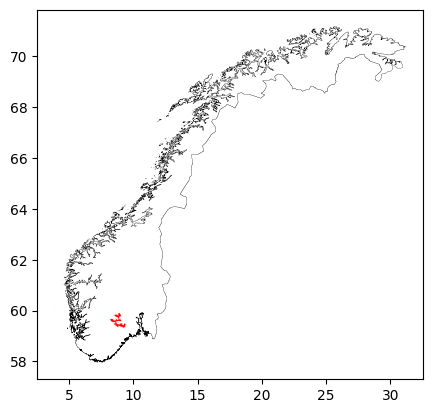

In [8]:
Norway = gpd.read_file(path_to_shape)

# Print the CRS of the Norway boundary
print(Norway.crs)

# Read in geometry of a random project
project = metadata_all_projects['ProjectMetadata'][11]
geometry = shape(project['geometry'])

# Create a GeoSeries from the project geometry
project_geom = gpd.GeoSeries(geometry)

# Print the CRS of the project geometry
print(project_geom.crs)

# If the project geometry doesn't have a CRS, you'll need to set it
# Replace 'epsg:4326' with the correct EPSG code for your project geometry
project_geom.crs = 'epsg:25833'

# Convert the project geometry to the CRS of the Norway boundary
project_geom = project_geom.to_crs(Norway.crs)

# Create the plot for the Norway boundary and get the axes
ax = Norway.plot(color='none', edgecolor='black', linewidth=0.2)

# Plot the project geometry on the same axes
project_geom.plot(ax=ax, color='red')

# Show the plot
# plt.show()

### making a raster of Norway and filling it with number of projects

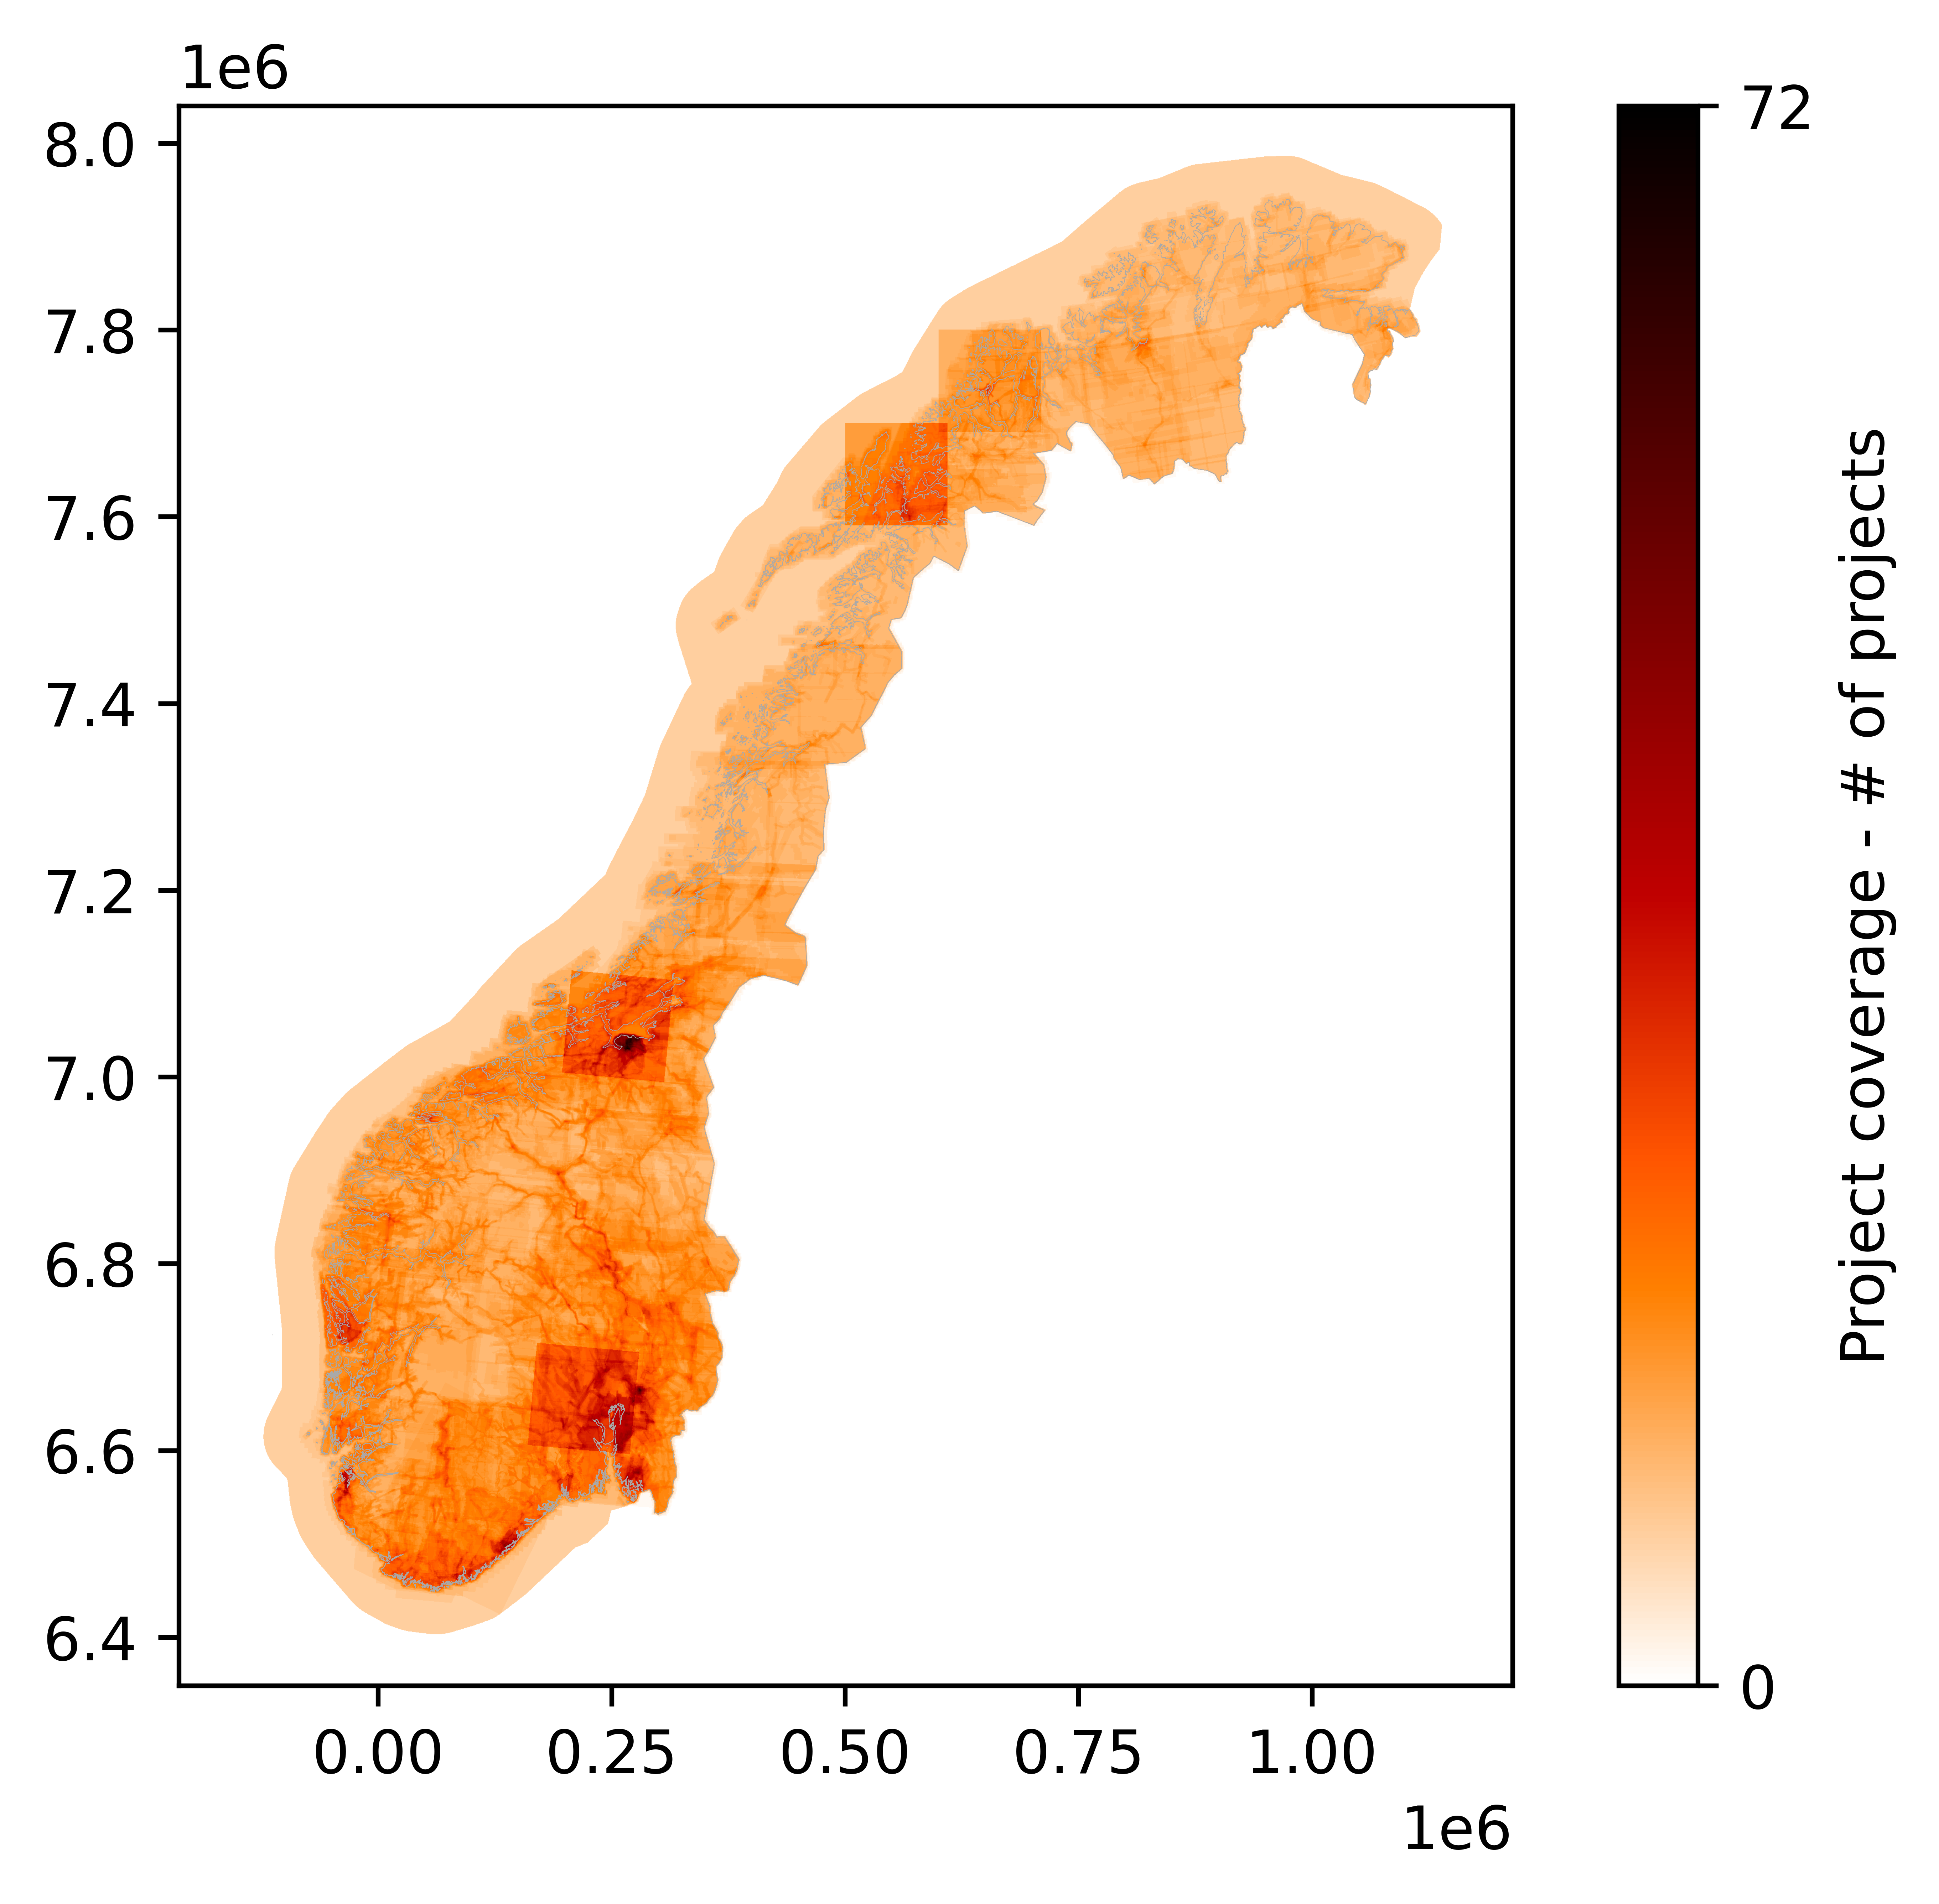

In [10]:
from rasterio.features import rasterize
from rasterio.transform import from_origin
from rasterio.plot import show
import matplotlib.cm as cm

def make_Norway_grid(name:str, resolution_m:int = 500):
    Norway = gpd.read_file(path_to_shape)
    Norway_utm = Norway.to_crs('epsg:25833')

    bounds, transform = get_transform_Norway(Norway_utm, resolution=resolution)
    # Calculate the width and height of the raster
    width = int(np.ceil((bounds[2] - bounds[0]) / resolution_m))
    height = int(np.ceil((bounds[3] - bounds[1]) / resolution_m))

    # Create an empty raster
    raster = rasterio.open(f'{name}.tif', 'w', driver='GTiff', height=height, width=width, count=1, 
                        dtype='uint16', crs=Norway_utm.crs, transform=transform)
    return

def make_project_grid(project, Norway_bounds:list, Norway_utm_transform, resolution:int = 500):
    '''
    Creates a raster of the same size as the norwegian one, with 1 in grids that the project
    covers and 0 else.
    '''
    # Get the geometry of the project
    geometry = shape(project['geometry'])

    # Create a GeoSeries from the project geometry
    project_geom = gpd.GeoSeries(geometry)

    # Set the CRS of the project geometry
    project_geom.crs = 'epsg:25833'

    # Convert the project geometry to EPSG:32633
    project_geom = project_geom.to_crsproject_geom = project_geom.to_crs('EPSG:32633')

    # Get the bounds of the Norway boundary
    bounds = Norway_bounds
    width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
    height = int(np.ceil((bounds[3] - bounds[1]) / resolution))
    # Create an empty raster
    orthophoto_raster = rasterize(project_geom, out_shape=(height, width), fill=0, default_value = 1, 
                                                transform=Norway_utm_transform, dtype='uint16')
    return orthophoto_raster

def get_transform_Norway(Norway_utm, resolution:int = 500):
    bounds = Norway_utm.total_bounds
    buffer  = 10**5
    bounds[0] -= buffer
    bounds[1] -= buffer
    bounds[2] += buffer
    bounds[3] += buffer
    #print(bounds)
    width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
    height = int(np.ceil((bounds[3] - bounds[1]) / resolution))
    transform = from_origin(bounds[0], bounds[3], resolution, resolution)
    return bounds, transform

def display_raster(raster,Norway_utm_transform, cmap = 'hot_r', save_as:str = None):
    fig, ax = plt.subplots()
    #ax.imshow(raster, cmap='hot_r')
    show(raster, ax=ax, transform=Norway_utm_transform, cmap=cmap)#, vmin = 0, vmax = 1)
    Norway_utm.boundary.plot(ax=ax, color='darkgrey', linewidth = 0.1)
    # Find max and min values of the raster
    max_val = np.max(raster)
    min_val = np.min(raster)

    # Create a ScalarMappable instance
    sm = cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_val, vmax=max_val))

    # Create a colorbar
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical', ticks=[min_val, max_val])
    cbar.set_label('Project coverage - # of projects')
    #plt.axis('off')
    
    if save_as:
        plt.savefig(save_as, dpi = 4200)
    plt.show()
    return

def add_projects_to_raster(projects:list, raster_name:str, Norway_utm_bound, 
                                            Norway_utm_transform, resolution:int = 500):
    p_rasters = []
    with rasterio.open(f'{raster_name}.tif', 'r+') as src:
        raster = src.read(1)
        for project in projects:
            p_grid = make_project_grid(project, Norway_utm_bound, Norway_utm_transform, resolution)
            #p_rasters.append(p_grid)
            raster += p_grid
        
        src.write(raster, 1)
    return

# Set the default DPI
plt.rcParams['figure.dpi'] = 1200

resolution = 500
make_Norway_grid(f'Norway_{resolution}', resolution)
Norway = gpd.read_file(path_to_shape)
Norway_utm = Norway.to_crs('epsg:25833')
bounds = Norway_utm.total_bounds
Norway_utm_bounds, Norway_utm_transform = get_transform_Norway(Norway_utm, resolution = resolution)
p_grid = make_project_grid(metadata_all_projects['ProjectMetadata'][11], Norway_utm_bounds, 
                                            Norway_utm_transform, resolution)
#display_raster(p_grid,Norway_utm_transform)

add_projects_to_raster(metadata_all_projects['ProjectMetadata'][0:], f'Norway_{resolution}', 
                                        Norway_utm_bounds, Norway_utm_transform, resolution = resolution)
with rasterio.open(f'Norway_{resolution}.tif') as src:
    raster = src.read(1)
    display_raster(raster,Norway_utm_transform, cmap = 'gist_heat_r')#, save_as = f'Project_density_{resolution}.png')
    # colormaps we tried: hot_r, Reds, gist_heat_r, 
    # still to try copper, autumn, inferno, magma, plasma, viridis, cividis

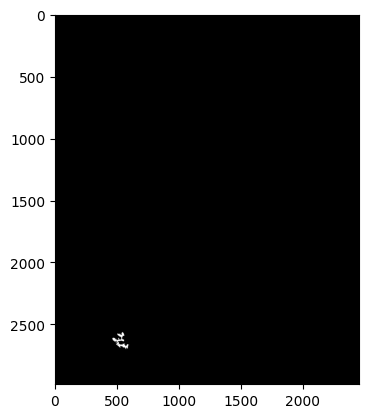

In [5]:
plt.imshow(p_grid, cmap = 'gray')

### make a grid across Norway

In [87]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

# Transform Norway to UTM zone 33N (appropriate for Norway)
Norway_utm = Norway.to_crs('EPSG:32633')

# Define the bounds and resolution of the raster
bounds = Norway_utm.total_bounds
resolution = 500  # The size of the pixels in meters

# Calculate the width and height of the raster
width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
height = int(np.ceil((bounds[3] - bounds[1]) / resolution))
print(f'our grid will be {width} x {height} pixels')

# Create a transform that maps pixel coordinates to spatial coordinates
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

# Create an empty raster
raster = rasterio.open('raster.tif', 'w', driver='GTiff', height=height, width=width, count=1, 
                       dtype='uint16', crs=Norway_utm.crs, transform=transform)

our grid will be 2457 x 2984 pixels


In [88]:
Norway.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

EPSG:32633
Number of non-zero values: 0


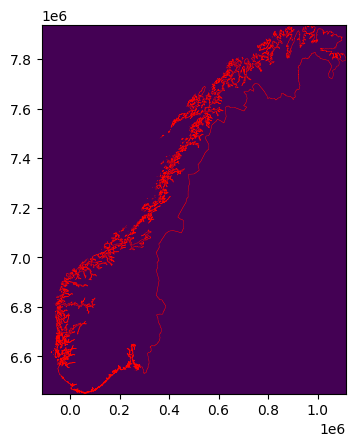

In [89]:
from rasterio.plot import show
raster.close()
# print raster
with rasterio.open('raster.tif') as src:
    # Read the raster data
    raster_data = src.read(1)
    print(src.crs)
    # Create a figure and axes
    fig, ax = plt.subplots()
    non_zero_count = np.count_nonzero(raster_data)
    print(f"Number of non-zero values: {non_zero_count}")
    # Plot the raster data
    #ax.imshow(raster_data, cmap='gray', extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]])
    show(raster_data, ax=ax, transform=src.transform, cmap='viridis')
    Norway_utm.boundary.plot(ax=ax, color='red', linewidth = 0.3)

In [94]:
from rasterio.features import rasterize
# Read in geometry of a random project
project = metadata_all_projects['ProjectMetadata'][11]
geometry = shape(project['geometry'])

# Create a GeoSeries from the project geometry
project_geom = gpd.GeoSeries(geometry)

# Print the CRS of the project geometry
print(project_geom.crs)

# If the project geometry doesn't have a CRS, you'll need to set it
# Replace 'epsg:4326' with the correct EPSG code for your project geometry
project_geom.crs = 'epsg:25833'

# Convert the project geometry to the CRS of the Norway boundary
project_geom = project_geom.to_crs('EPSG:32633')
resolution = 500
# get the bounds of the project geometry
bounds = project_geom.total_bounds
bounds = Norway_utm.total_bounds
width = int(np.ceil((bounds[2] - bounds[0]) / resolution))
height = int(np.ceil((bounds[3] - bounds[1]) / resolution))
transform = from_origin(bounds[0], bounds[3], resolution, resolution)

orthophoto_raster = rasterize(project_geom, out_shape=(height, width), fill=0, default_value = 1, transform=transform, dtype='uint16')

None


Number of non-zero values: 5083


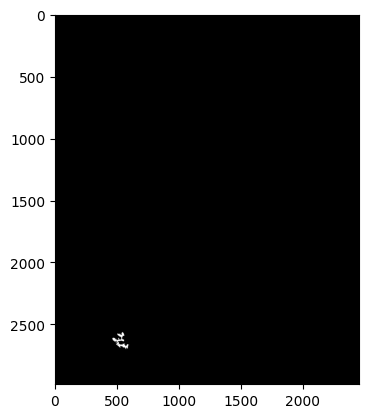

In [95]:
non_zero_count = np.count_nonzero(orthophoto_raster)
print(f"Number of non-zero values: {non_zero_count}")
import matplotlib.pyplot as plt

# Assuming orthophoto_raster is a 2D numpy array
plt.imshow(orthophoto_raster, cmap='gray')
plt.show()


In [96]:
# Open the existing raster file
with rasterio.open('raster.tif', 'r+') as src:
    # Read the existing raster data
    raster_data = src.read(1)

    # Create a new raster that has the same shape as the Norway raster
    new_orthophoto_raster = np.zeros_like(raster_data)
    orthophoto_bounds = bounds
    # Calculate the indices in the Norway raster that correspond to the bounds of the orthophoto raster
    left = int((orthophoto_bounds[0] - bounds[0]) / resolution)
    right = left + orthophoto_raster.shape[1]
    top = int((bounds[3] - orthophoto_bounds[3]) / resolution)
    bottom = top + orthophoto_raster.shape[0]

    # Copy the orthophoto raster into the corresponding part of the new raster
    new_orthophoto_raster[top:bottom, left:right] = orthophoto_raster

    # Add the new orthophoto raster to the Norway raster
    raster_data += new_orthophoto_raster
    raster_data += orthophoto_raster

    # Write the updated raster data back to the file
    src.write(raster_data, 1)

EPSG:32633
Number of non-zero values: 30539


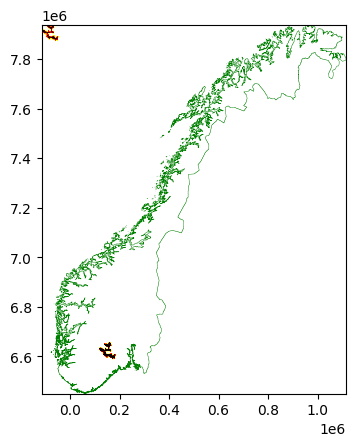

In [101]:
from rasterio.plot import show
raster.close()
# print raster
with rasterio.open('raster.tif') as src:
    # Read the raster data
    raster_data = src.read(1)
    print(src.crs)
    # Create a figure and axes
    fig, ax = plt.subplots()
    non_zero_count = np.count_nonzero(raster_data)
    print(f"Number of non-zero values: {non_zero_count}")
    # Plot the raster data
    #ax.imshow(raster_data, cmap='gray', extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]])
    show(raster_data, ax=ax, transform=src.transform, cmap='hot_r', vmin = 0, vmax = 1)
    Norway_utm.boundary.plot(ax=ax, color='green', linewidth = 0.3)

from rasterio.plot import show
raster.close()
# print raster
with rasterio.open('raster.tif') as src:
    # Read the raster data
    raster_data = src.read(1)
    print(src.crs)
    # Create a figure and axes
    fig, ax = plt.subplots()
    print(raster_data)
    # Plot the raster data
    #ax.imshow(raster_data, cmap='gray', extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]])
    show(raster_data, ax=ax, transform=src.transform, cmap='viridis')
    Norway_utm.boundary.plot(ax=ax, color='red', linewidth = 0.3)

In [38]:
from rasterio.features import geometry_mask

# Get the geometry of Norway as a list of shapes
shapes = [geometry for geometry in Norway['geometry']]

# Create a mask from the Norway shape
mask = geometry_mask(shapes, transform=raster.transform, out_shape=(raster.height, raster.width), invert=True)

# Apply the mask to the raster
raster.write(mask.astype(rasterio.uint16), 1)

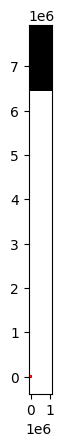

In [39]:
# Generate random noise
noise = np.random.rand(raster.height, raster.width)

# Write the noise to the raster
raster.write(noise.astype(rasterio.float32), 1)
# Close the raster file
raster.close()
# Reopen the raster file in read mode
with rasterio.open('raster.tif') as src:
    # Read the raster data
    raster_data = src.read(1)

    # Create a figure and axes
    fig, ax = plt.subplots()

    # Plot the raster data
    ax.imshow(raster_data, cmap='gray', extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]])

    # Plot the Norway boundaries
    Norway.boundary.plot(ax=ax, color='red')

    # Show the plot
    plt.show()

TypeError: Image data of dtype object cannot be converted to float

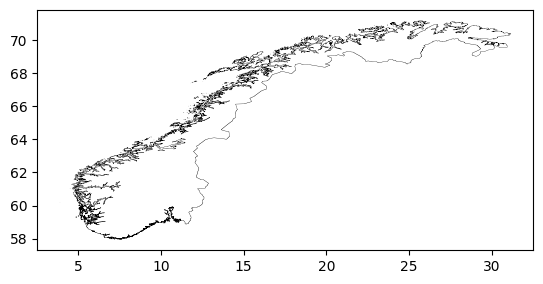

In [26]:
# Create the plot for the Norway boundary and get the axes
ax = Norway.plot(color='none', edgecolor='black', linewidth=0.2)
plt.imshow(raster)
